In [1]:
import os, sys, json, yaml
import shutil
import datetime
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from omegaconf import OmegaConf


from model.modelloader import load_checkpoint
from dataloader_n_aug.dataloader import present_dataset, get_balance_train_data
from trainer.trainer import Trainer
from logger.logger import Logger
from utils.util import *
from utils.sam import SAM

cwd = os.getcwd()

# Load config
config_file = 'config/config.yml'
all_config = OmegaConf.load((os.path.join(cwd, config_file)))['config']
seeding(all_config)

# Preprocessing

In [2]:
present_dataset(all_config)

Data collected! C:/Users/ASUS/COVID_19/data/train_split.txt
Data collected! C:/Users/ASUS/COVID_19/data/val_split.txt
Data collected! C:/Users/ASUS/COVID_19/data/test_split.txt
Name of the dataset: COVIDXR_dataset
Collected from the description of these github: https://github.com/lindawangg/COVID-Net
--------------------------------------------------
Labels and quantities of samples in train dataset: 
  normal       10083
pneumonia     7205
covid-19      2394
Name: labels, dtype: int64
For each epoch we employ the sequentially fold loader for each class in train dataset
--------------------------------------------------
Labels and quantities of samples in val dataset: 
  covid-19     100
pneumonia    100
normal       100
Name: labels, dtype: int64
--------------------------------------------------
Labels and quantities of samples in test dataset: 
  covid-19     214
pneumonia    105
normal       100
Name: labels, dtype: int64
--------------------------------------------------


Data collected! C:/Users/ASUS/COVID_19/data/train_split.txt


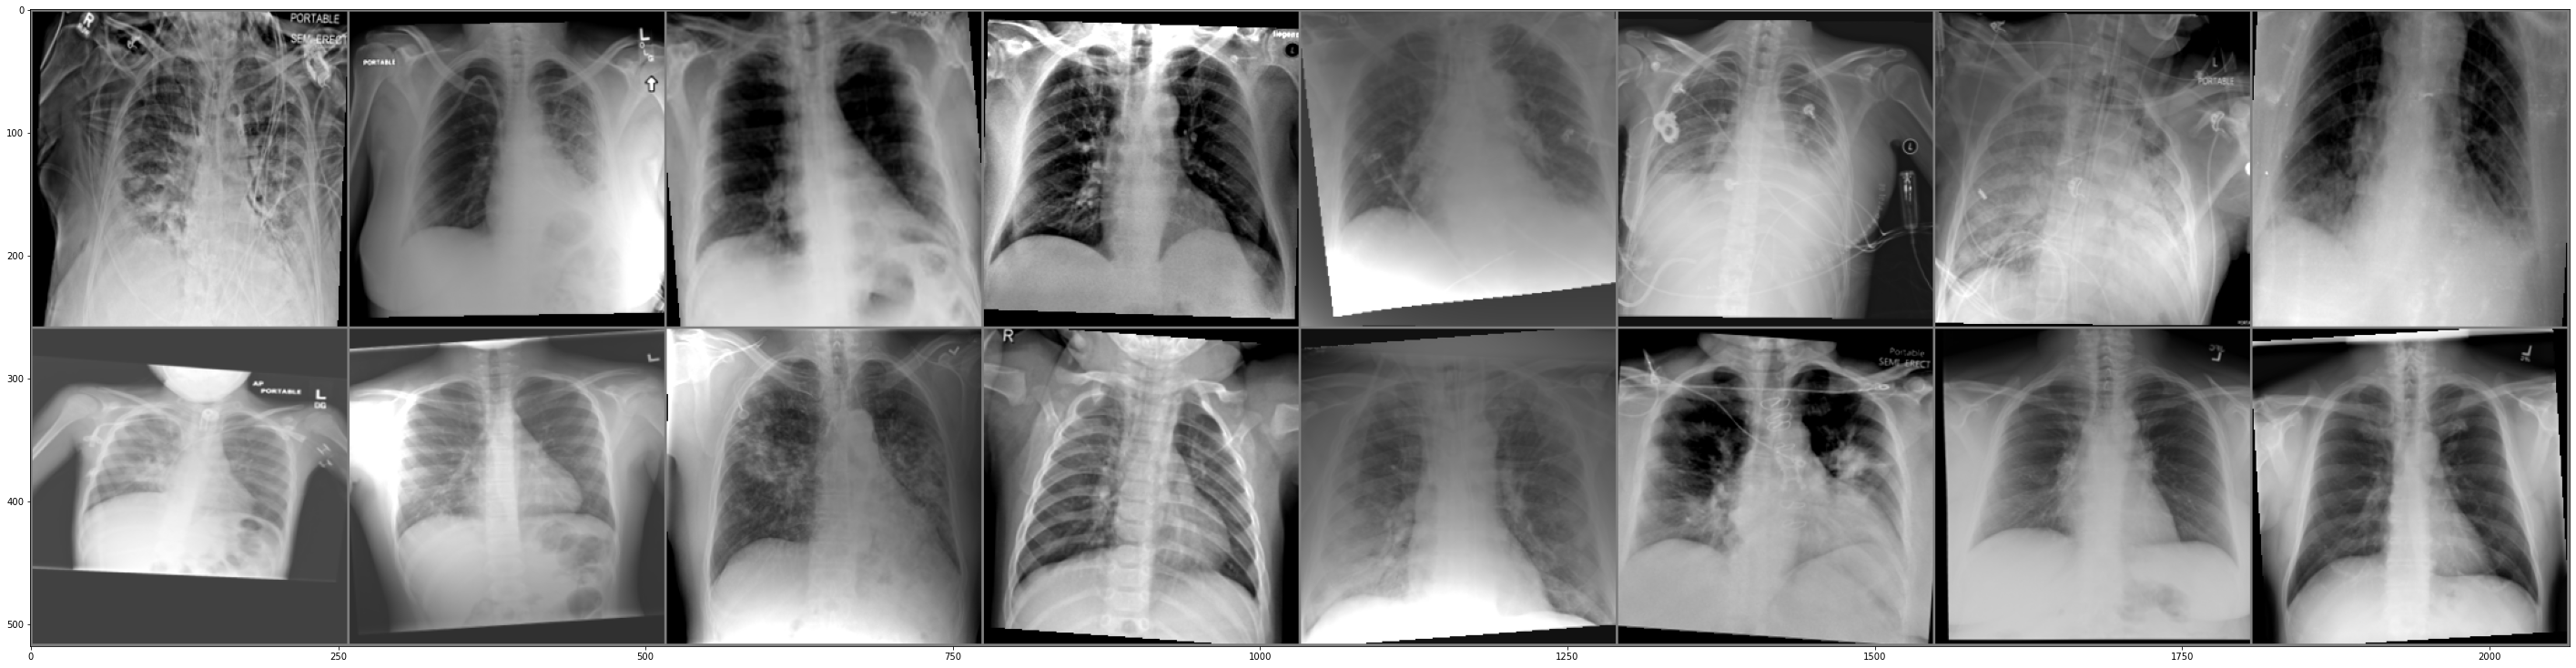

In [2]:
"""See augmentation!
"""
see_augmentation = get_balance_train_data(all_config)

inputs = next(iter(see_augmentation))
out = torchvision.utils.make_grid(inputs[0])
plt.figure(figsize=(50, 50))
augmentation2raw(all_config, out, show=True)

# Utility functions 

In [2]:
def select_scheduler_optimizer(model, config):
    opt = config['optimizer']['type']
    lr = config['optimizer']['lr']
    dec = config['optimizer']['weight_decay']
    optimizer = None
    
    if (opt == 'AdamW'):
        print("Create optimizer Adam with lr: ", lr)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=dec)
    
    elif (opt == 'SGD'):
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    elif (opt == 'SAM_SGD'):
        print("Create optimizer SAM SGD with lr: ", lr)

        base_optimizer = torch.optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
        
    elif(opt == 'SAM_AdamW'):
        print("Create optimizer SAM AdamW with lr: ", lr)

        base_optimizer = torch.optim.AdamW
        optimizer = SAM(model.parameters(), base_optimizer, lr=lr, weight_decay=dec)
        
        
    scheduler = ReduceLROnPlateau(optimizer, factor=config['scheduler']['scheduler_factor'],
                                      patience=config['scheduler']['scheduler_patience'],
                                      min_lr=config['scheduler']['scheduler_min_lr'],
                                      verbose=config['scheduler']['scheduler_verbose'])
    return optimizer, scheduler

# Train process

In [3]:
def engine(config):
    now = datetime.datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H.%M.%S")
    model_name = input("Choose model in your configuration: {model_ViT}, {model_PVT_V2}? : ")
    assert model_name in ['model_ViT', 'model_PVT_V2'], "You must decleare the model as in description!"
    print('-'*50)

    # Device
    device = torch.device("cuda:0" if (torch.cuda.is_available() and config.cuda) else "cpu")
    
    # Model
    model = get_model(config, model_name)
    # print(model.state_dict().keys())
    
    #Optimizer
    optimizer, scheduler = select_scheduler_optimizer(model, config[model_name])
    name_optimizer = config[model_name].optimizer.type
    
    # Remaining epochs
    start_epoch = 0
    
    # Load model from checkpoint if config.load_for_training = True
    if config.load_for_training:
        print('----- LOADING CHECKPOINTS -----')
        get_checkpoints(model_name)
        checkpoint_name = input("Choose one of these checkpoints above: ")
        cpkt_fol_name = os.path.join(config.cwd, f'checkpoints/{model_name}/{checkpoint_name}')   
        checkpoint_dirmodel = f'{cpkt_fol_name}/model_best_checkpoint.pth'
        model, optimizer, _, start_epoch = load_checkpoint(checkpoint_dirmodel, model, optimizer, scheduler) 
        optimizer_to_cuda(optimizer, device)
        
        print(f'Optimizer: {optimizer}')
        print(f'Start epoch: {start_epoch}')
    
    else:
        print('----- TRAINING NEW -----')
  
    # Freeze earlier layers
    if config.freeze:
        print('!!! Apply freezing layers !!!')
        model.freeze_layers()
    
    # Add to GPU (if able)
    model = torch.nn.DataParallel(model).to(device)
    
    
    # Create new checkpoint
    model_version = all_config[model_name].pretrained_cpkt.split('.')[0].replace('/', '')
    cpkt_fol_name = os.path.join(config.cwd, f'checkpoints/{model_name}/{model_version}_date_{dt_string}')
    
    # Logger
    logname = str('LOG_' + config[model_name].name)
    log = Logger(path=cpkt_fol_name, name=logname).get_logger()
    log.info(f"Checkpoint Folder {cpkt_fol_name} ")
    
    log.info(f"date and time = {dt_string}")
    log.info(f'pyTorch VERSION:{torch.__version__}', )
    log.info(f'CUDA VERSION:{torch.version.cuda}')
    log.info(f'CUDNN VERSION:{torch.backends.cudnn.version()}')
    log.info(f'Number CUDA Devices: {torch.cuda.device_count()}') 
    log.info(f'device: {device}')
    
    # Check trainabel params
    log.info(f"Total parameters: {sum(p.numel() for p in model.parameters())}") 
    log.info(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}") 
    
    # Trainer
    trainer = Trainer(config=config, model=model, 
                      optimizer=optimizer, 
                      name_optimizer=name_optimizer,
                      logger=log,
                      start_epoch=start_epoch,
                      lr_scheduler=scheduler,             
                      checkpoint_dir=cpkt_fol_name)
    
    trainer.train()

In [ ]:
engine(all_config)